In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('GoogleStocks.csv')
dataset = dataset.iloc[1:]
p = ['close', 'volume', 'open', 'high', 'low']
for i in p:
        dataset[i] = dataset[i].replace(',','', regex=True).astype(float)
dataset = dataset.sort_values(by='date')
dataset['Avg'] = (dataset['high']+dataset['low'])/2.0
dataset['date']= pd.to_datetime(dataset['date'])
dataset = dataset[['volume','Avg','open']]
print(dataset.head())
dataset_train,dataset_test = train_test_split(dataset, shuffle=False,test_size=0.2)


trainset = dataset_train.iloc[:,0:2].values
Y = dataset_train.iloc[:,2:3].values
testset = dataset_test.iloc[:,0:2].values
sc = MinMaxScaler(feature_range = (0,1))
training_set = sc.fit_transform(trainset)
test = sc.fit_transform(testset)
Y = sc.fit_transform(Y)

print(training_set.shape)
print(Y.shape)

print(test.shape)

        volume      Avg    open
755  1300817.0  735.745  736.79
754  1902254.0  738.005  734.59
753  1782278.0  753.310  750.10
752  1718638.0  745.895  749.25
751  1576240.0  743.670  738.60
(604, 2)
(604, 1)
(151, 2)


In [3]:
def RNN(timestep,hidden1,hidden2):
    X_train = []
    y_train = []
    for i in range(timestep, training_set.shape[0]):
        X_train.append(training_set[i-timestep:i])
        y_train.append(Y[i])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1], 2))
    print(X_train.shape)
    print(test.shape)
    # MODEL ------------------------------------------------------------------

    regressor = Sequential()
    regressor.add(LSTM(units = hidden1, return_sequences=True, input_shape = (X_train.shape[1], 2))) 
    regressor.add(Dropout(0.2))
#     regressor.add(LSTM(units = hidden2, return_sequences=True, input_shape = (X_train.shape[1], 1))) 
#     regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = hidden2)) 
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=16,activation='relu'))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=1,activation='relu'))    

    # -------------------------------------------------------------------------
    regressor.compile(optimizer='adam', loss = 'mean_squared_error')   
    regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)
    
    Yt = dataset_test.iloc[timestep:,2:3].values
    real_stock_price = Yt
    Yt = sc.fit_transform(Yt)
    x_test = []
#     y_test = []
    for i in range(timestep,test.shape[0]):
        x_test.append(test[i-timestep:i])
#         y_test.append(Yt[i])
    x_test = np.array(x_test)
    print(x_test.shape)
    y_test = Yt
#     print(x_test.shape)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],2))
    print(x_test.shape)
    predicted_price = regressor.predict(x_test)
    predicted_price = sc.inverse_transform(predicted_price)
#     real_stock_price = real_stock_price.astype(np.float64, copy=False)
    predicted_price = predicted_price.astype(np.float64,copy=False)
    print(predicted_price.shape)
    return real_stock_price,predicted_price

# print(math.sqrt(mean_squared_error(real_stock_price, predicted_price)))

In [4]:
timestep,hidden1,hidden2 = (20,50,50)
real_stock_price,predicted_price = RNN(timestep,hidden1,hidden2)

(584, 20, 2)
(151, 2)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
584/584 [==============================] - 2s 3ms/step - loss: 0.2131
Epoch 2/50
584/584 [==============================] - 0s 750us/step - loss: 0.0466
Epoch 3/50
584/584 [==============================] - 0s 756us/step - loss: 0.0198
Epoch 4/50
584/584 [==============================] - 0s 734us/step - loss: 0.0142
Epoch 5/50
584/584 [==============================] - 1s 857us/step - loss: 0.0161
Epoch 6/50
584/584 [==============================] - 1s 995us/step - loss: 0.0144
Epoch 7/50
584/584 [==============================] - 1s 994us/step - loss: 0.0128
Epoch 8/50
584/584 [==============================] - 1s 1ms/step - loss: 0.0130
Epoch 9/50
584/584 [==============================] - 1s 1ms/step - loss: 0.0126
Ep

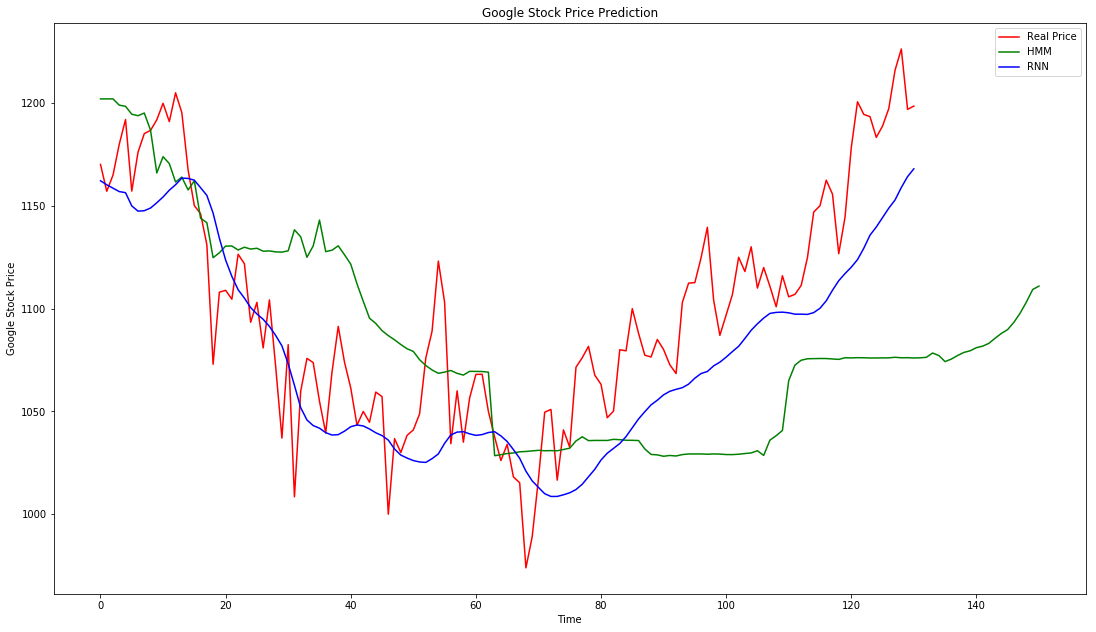

In [7]:
data = pd.read_csv("GoogleStocks.csv")
data = pd.read_csv('GoogleStocks.csv')
data = data.iloc[1:]
p = ['close', 'volume', 'open', 'high', 'low']
for i in p:
        data[i] = data[i].replace(',','', regex=True).astype(float)
data = data.sort_values(by='date')
data['Avg'] = (data['high']+data['low'])/2
data = data.sort_values(by='date')
data_train, data_test = train_test_split(data, test_size=0.2, shuffle=False)
predicted_open_prices = []
actual_open_prices = []
def compute_all_possible_outcomes(data):
    mu      = data.mean()
    sigma   = data.std()
    out = (sigma * np.random.standard_normal(1000)) + mu         
    return out

def prediction(day_index,time_step,data):
    previous_data_start_index = max(0, day_index - time_step)
    previous_data_end_index   = max(1, day_index - 1)
    previous_data = data.iloc[previous_data_start_index: previous_data_end_index]
    open_     = np.array(previous_data.loc[:,'open'])
    volume    = np.array(previous_data.loc[:,'volume'])
    avg_price = np.array(previous_data.loc[:,'Avg'])
    previous_features = np.column_stack((avg_price, volume, open_))
    possible_outcomes = compute_all_possible_outcomes(previous_features[:,-1])
    outcome_score = []
    for possible_outcome in possible_outcomes:
        total_data = np.column_stack((previous_features[:,:-1], [possible_outcome]*previous_features.shape[0]))
        outcome_score.append(hmm.score(total_data))
    most_probable_outcome = possible_outcomes[np.argmax(outcome_score)]
    return most_probable_outcome

def predict_close(days,time_step,data):
    global predicted_open_prices
    predicted_open_prices = []
    for day_index in range(days):
        predicted_open_prices.append(prediction(day_index,time_step,data))
    days = np.array(data['date'])
    actual_open_prices = data['open']
def model_train(data):
    open_     = np.array(data.loc[:,'open'])
    volume    = np.array(data.loc[:,'volume'])
    avg_price = np.array(data.loc[:,'Avg'])
    feature_vector = np.column_stack((avg_price, volume, open_))
    hmm.fit(feature_vector)
    predict_close(len(data_test),time_step,data_test)

time_step = 20
hmm = GaussianHMM(n_components=12)
model_train(data)

plt.plot(real_stock_price,color = 'red', label = 'Real Price')
plt.plot(predicted_open_prices,color = 'green', label = 'HMM')
plt.plot(predicted_price, color = 'blue', label = 'RNN')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
# plt.show()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)